# Taxi Order Analysis

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
import pandas as pd

In [3]:
'''
For some reason the usual path (/datasets/taxi.csv) was returning a FileNotFoundError,
so I uploaded the dataset to the same location as the notebook and did the following
'''

try:
    df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


## Analysis

**Whole Data**

In [6]:
df_resampled = df.resample('1H').sum()

In [7]:
df_resampled.isna().sum()

num_orders    0
dtype: int64

In [8]:
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
decomposed = seasonal_decompose(df_resampled)

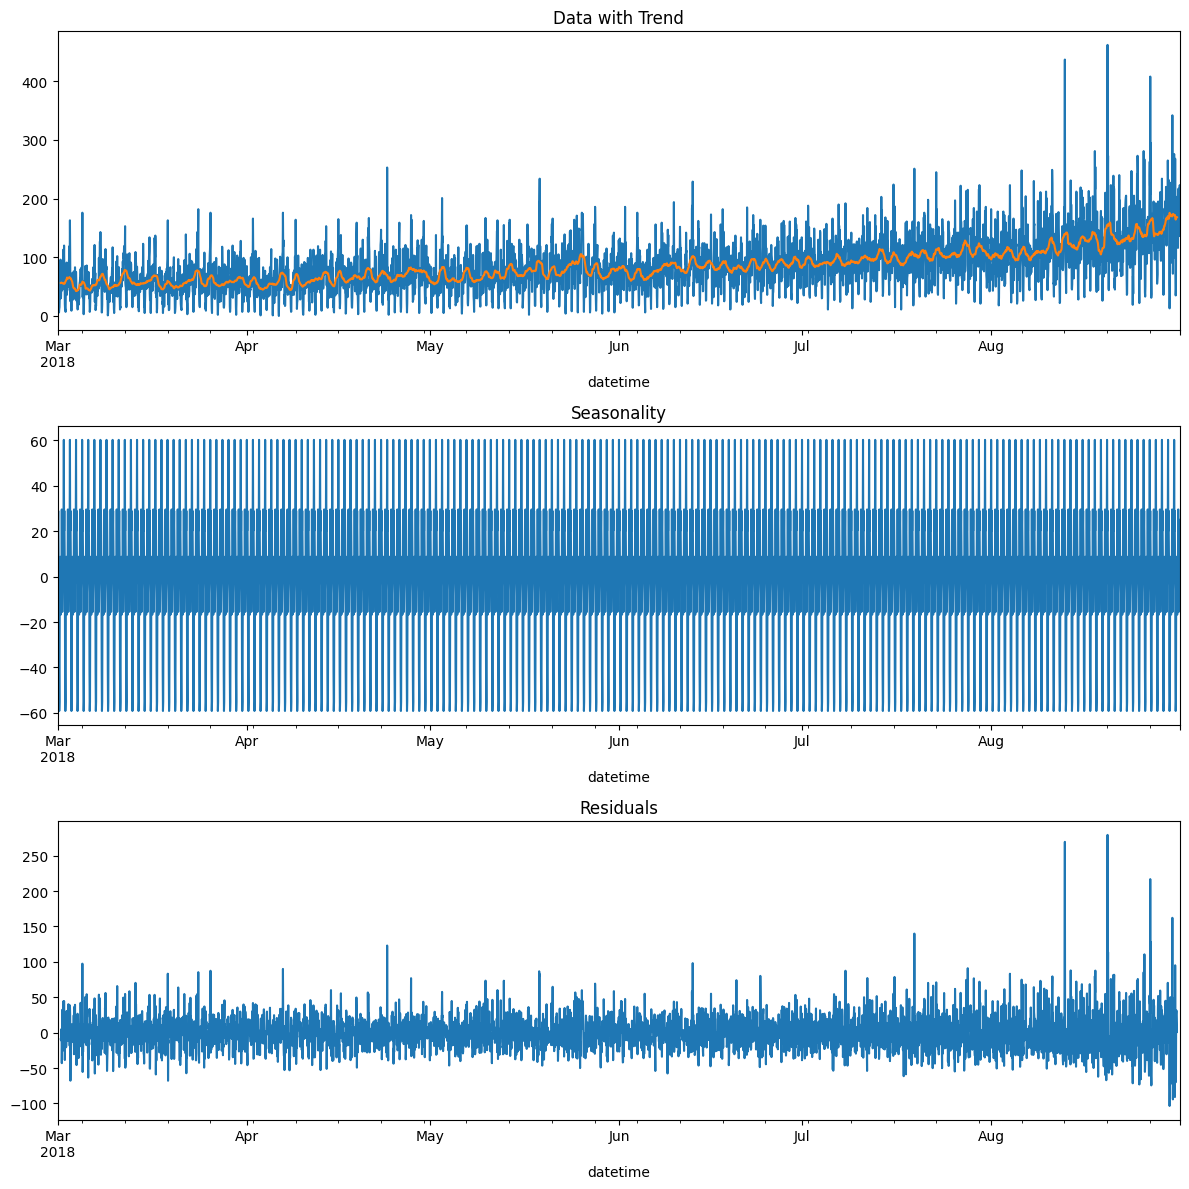

In [10]:
# seasonal decomposition to view data, trend and seasonality
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.observed.plot(ax=plt.gca())
decomposed.trend.plot()
plt.title('Data with Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**Mean**: It appears relatively stable, indicating that the average number of orders doesn’t fluctuate too much despite variations in total orders.  

**Sum**: This line represents the total number of orders over time. There are visible spikes, which could indicate peak ordering times or specific events causing increased activity.  

**Standard Deviation**: This line shows the variability in the number of orders. Higher values indicate more inconsistency in the number of orders.  

From these results, you can infer that while there are fluctuations and variability in the total number of orders, the average number of orders remains relatively stable. The peaks in the total orders might correspond to specific events or promotions that cause increased activity.

**Month of March**

In [11]:
march = df_resampled['2018-03-01' : '2018-03-31']

In [12]:
march.describe()

,num_orders
count,744.000000
mean,57.483871
std,29.562439
min,1.000000
25%,39.000000
50%,55.000000
75%,75.000000
max,182.000000


In [13]:
decomposed = seasonal_decompose(march)

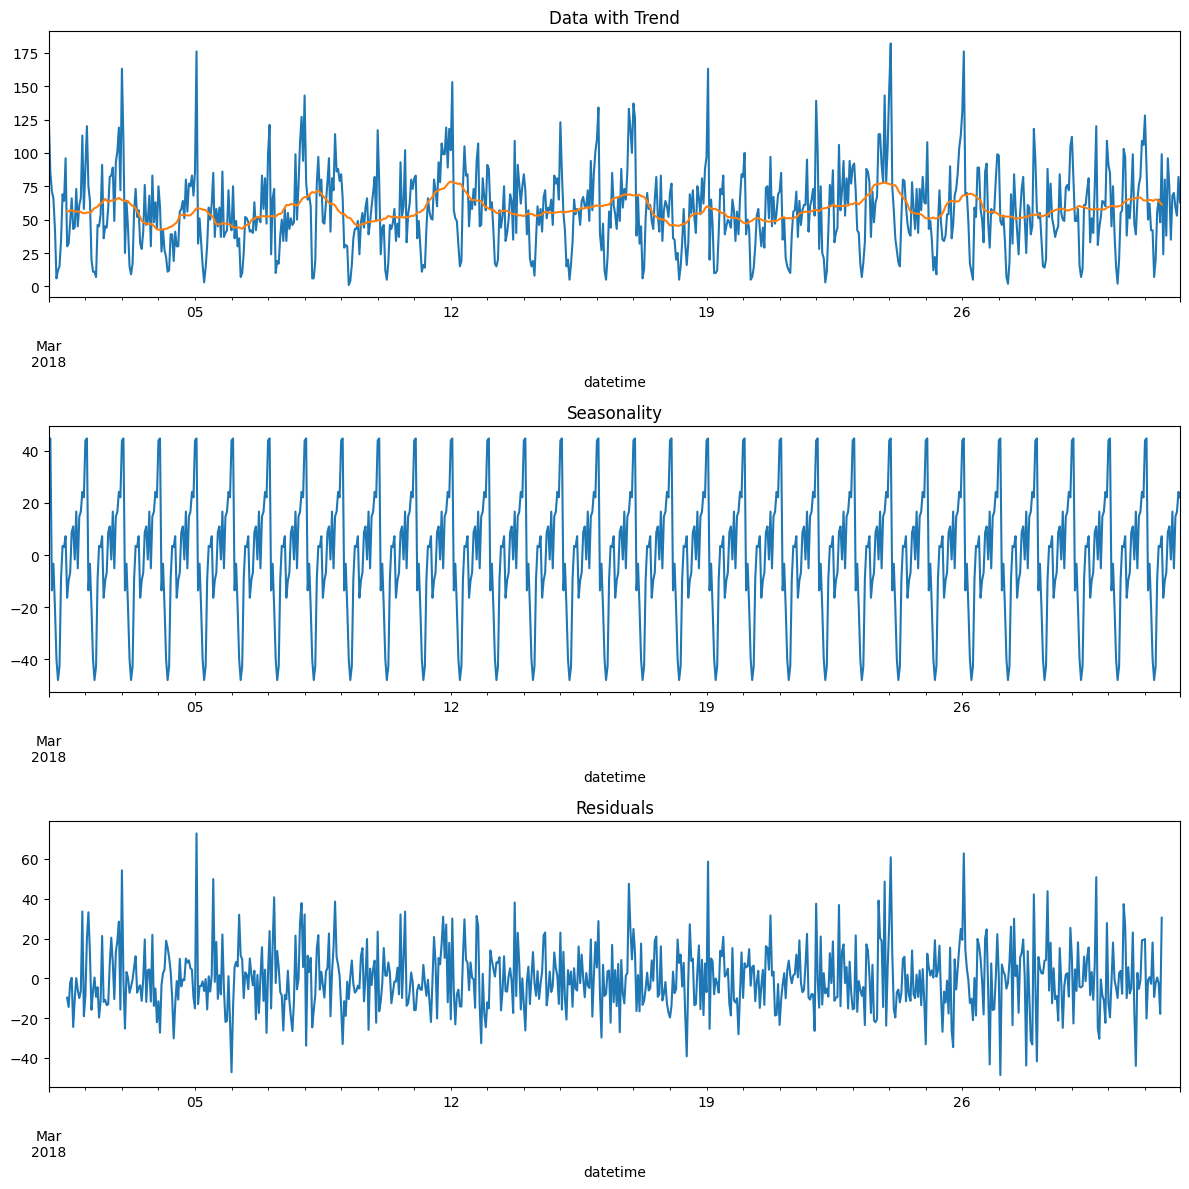

In [14]:
# seasonal decomposition to view data, trend and seasonality
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.observed.plot(ax=plt.gca())
decomposed.trend.plot()
plt.title('Data with Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**High Variability in Orders**: The ‘num_orders’ line fluctuates significantly, indicating that the number of orders varies greatly from day to day.  

**Stable Average**: The ‘mean’ line is smoother and runs through the center of the ‘num_orders’ fluctuations, suggesting that the average number of orders remains relatively stable over the month.  

**Consistent Spread**: The ‘std’ (standard deviation) line is relatively stable, indicating that the variability in the number of orders is consistent around the mean.  

This suggest that while there is considerable day-to-day variation in the number of orders, the overall average and the spread of the data remain fairly consistent.

**Conclusion**

The analysis of the taxi data reveals that while there is significant day-to-day variability in the number of orders, the overall average number of orders remains stable throughout the month. Additionally, the consistent spread of the data, as indicated by the stable standard deviation, suggests that the variability around the mean is uniform. These findings imply that despite the fluctuations in daily orders, the general trend and dispersion of the data are steady, providing a reliable basis for further analysis and modeling.

## Training

In [15]:
def make_features(data, max_lag, rolling_mean_size):

    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(df_resampled,3,3)

In [17]:
df_resampled.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
hour            0
lag_1           1
lag_2           2
lag_3           3
rolling_mean    3
dtype: int64

In [18]:
df_resampled = df_resampled.dropna()

In [19]:
df_resampled.isin([np.inf, -np.inf]).sum()


num_orders      0
month           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
rolling_mean    0
dtype: int64

In [20]:
#setting frequency for use in the SARIMA(X) model
df_resampled.index = pd.date_range(start=df_resampled.index[0], periods=len(df_resampled),freq='H')

In [21]:
features = df_resampled.drop('num_orders',axis=1)
target = df_resampled['num_orders']

In [22]:
#Perform the split once
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10, random_state=12345) 

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Training features shape: (3971, 8)
Test features shape: (442, 8)
Training target shape: (3971,)
Test target shape: (442,)


**Sets for ARIMA/SARIMA**

In [23]:
train_size = int(len(target) * 0.1)
train, test = target[:-train_size], target[-train_size:]

In [27]:
print(train.shape)
print(test.shape)

(3972,)
(441,)


**ARIMA**

In [28]:
arima_params=[(1,1,5),(3,2,3),(4,1,4)]
best_rmse = float('inf')
best_arima_pred = None
best_arima_order = None

for order in arima_params:
    arima_model = ARIMA(train, order=order)
    arima_result = arima_model.fit(start_params=[0.1]*sum(order))
    arima_pred = arima_result.predict(start=len(train), end=len(train) + len(test) -1, dynamic=False)
    

    arima_rmse = np.sqrt(mean_squared_error(test,arima_pred))
    
    print(f"ARIMA order = {order} RMSE: {arima_rmse:.2f}")
    
    if arima_rmse < best_rmse:
        best_rmse = arima_rmse
        best_arima_pred = arima_pred
        best_arima_order = order
print(f"Best ARIMA model: Order={best_arima_order}")
print(f"Best RMSE: {best_rmse:.2f}")

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA order = (1, 1, 5) RMSE: 64.81


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA order = (3, 2, 3) RMSE: 68.00


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA order = (4, 1, 4) RMSE: 63.49
Best ARIMA model: Order=(4, 1, 4)
Best RMSE: 63.49


**SARIMA**

In [31]:
sarima_params = [
    {'order': (1,0,0), 'seasonal_order': (1,0,0,12)},
    {'order': (0,1,0), 'seasonal_order': (0,1,0,12)}
]

best_rmse = float('inf')
best_sarima_pred = None
best_sarima_order = None

for params in sarima_params:
    order = params['order']
    seasonal_order = params['seasonal_order']
    sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    sarima_result = sarima_model.fit(disp=False)
    
    sarima_pred = sarima_result.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    
    sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
    
    print(f"SARIMA order={order}, seasonal_order={seasonal_order} RMSE: {sarima_rmse:.2f}")
    
    if sarima_rmse < best_rmse:
        best_rmse = sarima_rmse
        best_sarima_pred = sarima_pred
        best_sarima_order = order
        best_seasonal_order = seasonal_order
        
print(f"Best SARIMA Model: Order={best_sarima_order}, Seasonal_Order={best_seasonal_order}")
print(f"Best RMSE: {best_rmse:.2f}")

SARIMA order=(1, 0, 0), seasonal_order=(1, 0, 0, 12) RMSE: 150.22
SARIMA order=(0, 1, 0), seasonal_order=(0, 1, 0, 12) RMSE: 7284.80
Best SARIMA Model: Order=(1, 0, 0), Seasonal_Order=(1, 0, 0, 12)
Best RMSE: 150.22


In [38]:
# Reviewer's code 5 

best_params = {'maxiter': 60, 'method': 'lbfgs', 'order': (5, 1, 0), 
 'out_of_sample_size': 0, 'scoring': 'mse', 'seasonal_order': (1, 0, 0, 24), 'start_params': None, 'trend': None}

order = (best_params['order'][0], best_params['order'][1], best_params['order'][2])
seasonal_order = (best_params['seasonal_order'][0], best_params['seasonal_order'][1], best_params['seasonal_order'][2], best_params['seasonal_order'][3])

p, d, q = best_params['order']
P, D, Q, m = best_params['seasonal_order']

sarimax_model = SARIMAX(train.values, order=order, seasonal_order=seasonal_order)
sarimax_fit = sarimax_model.fit(disp=False)

sarima_pred = sarimax_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    
np.sqrt(mean_squared_error(test, sarima_pred))

59.94451154771563

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"RMSE: {rmse_lr}")

RMSE: 29.33331117338487


In [32]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=12345)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_rf = RandomForestRegressor(**best_params, random_state=12345)
best_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = best_rf.predict(X_test)

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE after hyperparameter tuning: {rmse_rf}")

Best parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
RMSE after hyperparameter tuning: 22.39946704994128


**Model Comparison**

In [33]:
model_comparison = {
    'Model': ['ARIMA', 'SARIMA', 'Linear Regression', 'Random Forest'],
    'Best Order': [best_arima_order, best_sarima_order, None, best_params],
    'Best Seasonal Order': [None, best_seasonal_order, None, None],
    'RMSE': [best_rmse, best_rmse, rmse_lr, rmse_rf]
}

# Convert the dictionary to a DataFrame
comparison_df = pd.DataFrame(model_comparison)

In [37]:
comparison_df

,Model,Best Order,Best Seasonal Order,RMSE
0,ARIMA,"(4, 1, 4)",None,150.215925
1,SARIMA,"(1, 0, 0)","(1, 0, 0, 12)",150.215925
2,Linear Regression,None,None,29.333311
3,Random Forest,"{'max_depth': 20, 'min_samples_split': 10, 'n_...",None,22.399467


# Overall Conclusion

**Stable Average Orders**: Despite fluctuations in the total number of orders, the average number of orders remains relatively stable. This indicates that the business experiences consistent demand over time.  
**High Variability in Daily Orders**: The number of orders varies significantly from day to day, as evidenced by the fluctuating ‘num_orders’ line. This suggests that there are specific days or events that cause spikes in orders, possibly due to promotions or special events.  
**Consistent Variability**: The standard deviation line remains relatively stable, indicating that the variability in the number of orders is consistent around the mean. This consistency in variability suggests that while the total number of orders fluctuates, the degree of fluctuation is predictable.  
**Model Performance**:  

ARIMA Models: The best ARIMA model is with order (4, 1, 4), achieving an RMSE of 63.49.

SARIMA Models: The best SARIMA model is with order (1, 0, 0) and seasonal order (1, 0, 0, 12), achieving an RMSE of 150.22.  

Hyperparameter Tuning: After hyperparameter tuning, the best parameters for the model were found to be {‘max_depth’: 20, ‘min_samples_split’: 10, ‘n_estimators’: 200}. The RMSE of the model after tuning is 22.399, indicating the model’s accuracy in predicting the number of orders.  

Overall, the business can expect a stable average number of orders with predictable variability, despite occasional spikes due to specific events. The tuned model provides a reliable tool for forecasting future orders, helping in better planning and resource allocation.  